In [13]:
# Import packages

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import rand_score, adjusted_rand_score
import networkx as nx
import torch
import torch.nn as nn


from libraries.preprocess import load_ts_dataset, distance_matrix, epsilon_graph_hard, epsilon_graph_mean
from libraries.nmf import nmf, nmf_sklearn, semi_nmf, sym_nmf, rgnmf_multi, kernel_nmf, sparse_nmf
from libraries.clustering_algos import kmeans, gaussian_mixture, spectral_clustering, node2vec_clustering
from libraries.deepnmf import DeepNMF, DeepNMFLoss, DANMF, DANMFLoss, deep_autoencoder_nmf, deep_nmf

In [14]:
# list of datasets available in the UCR base
# ['Adiac', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken', 'Car', 'CBF', 'ChlorineConcentration', 'CinCECGTorso', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'DiatomSizeReduction', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxTW', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'GunPoint', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'InlineSkate', 'InsectWingbeatSound', 'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lightning2', 'Lightning7', 'Mallat', 'Meat', 'MedicalImages', 'MiddlePhalanxOutlineCorrect', 'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxTW', 'MoteStrain', 'NonInvasiveFatalECGThorax1', 'NonInvasiveFatalECGThorax2', 'OliveOil', 'OSULeaf', 'PhalangesOutlinesCorrect', 'Phoneme', 'Plane', 'ProximalPhalanxOutlineCorrect', 'ProximalPhalanxOutlineAgeGroup', 'ProximalPhalanxTW', 'RefrigerationDevices', 'ScreenType', 'ShapeletSim', 'ShapesAll', 'SmallKitchenAppliances', 'SonyAIBORobotSurface1', 'SonyAIBORobotSurface2', 'StarLightCurves', 'Strawberry', 'SwedishLeaf', 'Symbols', 'SyntheticControl', 'ToeSegmentation1', 'ToeSegmentation2', 'Trace', 'TwoLeadECG', 'TwoPatterns', 'UWaveGestureLibraryX', 'UWaveGestureLibraryY', 'UWaveGestureLibraryZ', 'UWaveGestureLibraryAll', 'Wafer', 'Wine', 'WordSynonyms', 'Worms', 'WormsTwoClass', 'Yoga', 'ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms', 'Epilepsy', 'EthanolConcentration', 'ERing', 'FaceDetection', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'InsectWingbeat', 'JapaneseVowels', 'Libras', 'LSST', 'MotorImagery', 'NATOPS', 'PenDigits', 'PEMS-SF', 'Phoneme', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits', 'StandWalkJump', 'UWaveGestureLibrary']

# used datasets in the original paper
# Beef, CinCECGTorso, Coffee, DiatomSizeReduction, ECGFiveDays, MoteStrain, OliveOil, SonyAIBORobotSurface1, SonyAIBORobotSurface2, Symbols, TwoLeadECG

In [15]:
# This cell defines the methods and their hyperparameters to test on a list of UCR datasets. You can comment unwanted methods and datasets

# list of methods and parameters
methods = {
    node2vec_clustering: [128, 50, 25, 0.5, 2, False], # n_dim embedding, n length of walks, length of walks, p, q, direct
    kmeans: [False], # direct
    gaussian_mixture: [False], # direct
    spectral_clustering: [False], # direct
    nmf_sklearn: [1000], # max_iter
    semi_nmf: [1000, False], # max_iters, safeguard
    sym_nmf: [1e-4, 0.1, 1000], # lr, sigma, max_iters
    #rgnmf_multi: [1e-2, 1, 1000, False, 1e-4, 1e4], # alpha, bera, max_iters, safeguard, lower_limit, higher_limit
    kernel_nmf: ['gaussian', 1.0, 3, 1.0, 1.0, 500], # kernel, sigma, degree, alpha, beta, max_iters
    sparse_nmf: [0.1, 0.1, 100], # beta, eta, max_iters
    deep_nmf: [0.01, 1000, False], # lr, nb_iters, visualize
    deep_autoencoder_nmf: [0.01, 1000, 1.0, False], # lr, nb_iters, sparsity_regularization, visualize
}

# list of datasets and parameters
hyperparameters = {
    'SonyAIBORobotSurface1': 50,
    'SonyAIBORobotSurface2': 50,
    'Beef': 50,
    'CinCECGTorso': 50,
    'Coffee': 50,
    'DiatomSizeReduction': 50,
    'ECGFiveDays': 50,
    'MoteStrain': 50,
    'OliveOil': 50,
    'Symbols': 50,
    'TwoLeadECG': 50,
}

In [16]:
def test(methods, hyperparameters):
    # parameters for the testing
    epsilon_factor = 0.9
    
    # output dict
    output_dict = {}
    
    for dataset_name in hyperparameters.keys():
        print(f'Starting dataset {dataset_name}')
        # prepare output_dict
        output_dict[dataset_name] = {}
        
        # import dataset
        dataset = load_ts_dataset(dataset_name)
        data, true_labels = dataset[0], dataset[1]
        # build normalized distance matrix
        dist = distance_matrix(data)
        dist_n = dist / np.max(dist)

        # print number of classes of the dataset
        nb_clusters = len(np.unique(true_labels))
        print(f'Dataset has {nb_clusters} clusters !')
        
        # random partition to compare
        random_score = np.mean([rand_score(true_labels, np.random.randint(low=0, high=nb_clusters, size=len(dist))) for i in range(1000)])
        
        # test each method
        for method in methods.keys():
            print(f'Starting method {method.__name__}')
            eps = []
            residuals = []
            rands = []
            preds = []

            # start epsilon sweep
            for i in range(hyperparameters.get(dataset_name)):
                ep = epsilon_factor**i
                Anp = epsilon_graph_hard(dist_n, epsilon=ep)
                W, H, residual = method(Anp, nb_clusters, *(methods.get(method)))
                residuals.append(residual)
                eps.append(ep)
                preds.append(np.argmax(W, axis=1))
                rands.append(rand_score(true_labels, np.argmax(W, axis=1)))
            
            # find best epsilon
            idx = np.argmax(rands)

            output_dict[dataset_name][method] = {'eps': eps,
                                                'residuals': residuals,
                                                'rands': rands,
                                                'preds': preds,
                                                'best_epsilon': eps[idx],
                                                'epsilon_quantile': len(dist_n.flatten()[dist_n.flatten() <= eps[idx]]) / len(dist_n.flatten())
                                                }
    
    return output_dict



In [17]:
# sometimes kmeans raises a package error, but relaunching the cell should work
import warnings
warnings.simplefilter('ignore')
output = test(methods, hyperparameters)

Starting dataset SonyAIBORobotSurface1
Dataset has 2 clusters !
Starting method node2vec_clustering
Starting method kmeans
Starting method gaussian_mixture
Starting method spectral_clustering
Starting method nmf_sklearn
Starting method semi_nmf
Starting method sym_nmf
Starting method kernel_nmf
Starting method sparse_nmf
0.1 0.1 100
Iteration 100, residual norm 3.1116068621974486
0.1 0.1 100
Iteration 100, residual norm 4.082690267013192
0.1 0.1 100
Iteration 100, residual norm 4.06978037068084
0.1 0.1 100
Iteration 100, residual norm 3.4412417571045912
0.1 0.1 100
Iteration 100, residual norm 3.1665917614274512
0.1 0.1 100
Iteration 100, residual norm 3.095659149503076
0.1 0.1 100
Iteration 100, residual norm 2.4639975012017787
0.1 0.1 100
Iteration 100, residual norm 2.241439101598205
0.1 0.1 100
Iteration 100, residual norm 1.3709852065335113
0.1 0.1 100
Iteration 100, residual norm 0.8769439767645465
0.1 0.1 100
Iteration 100, residual norm 0.5694479829463032
0.1 0.1 100
Iteration 

SonyAIBORobotSurface1


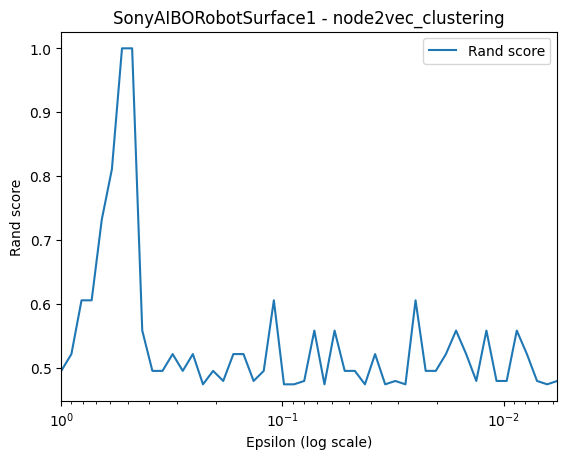

SonyAIBORobotSurface2


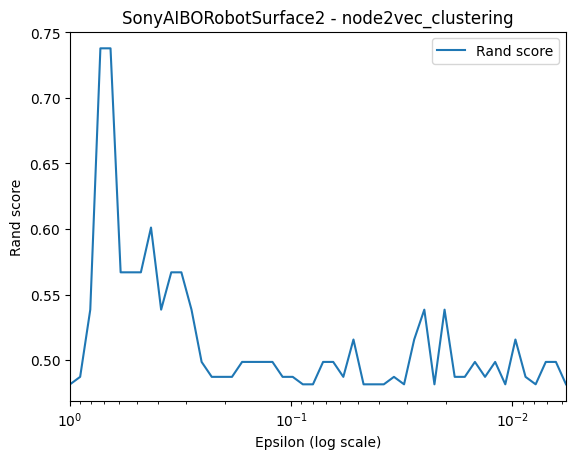

Beef


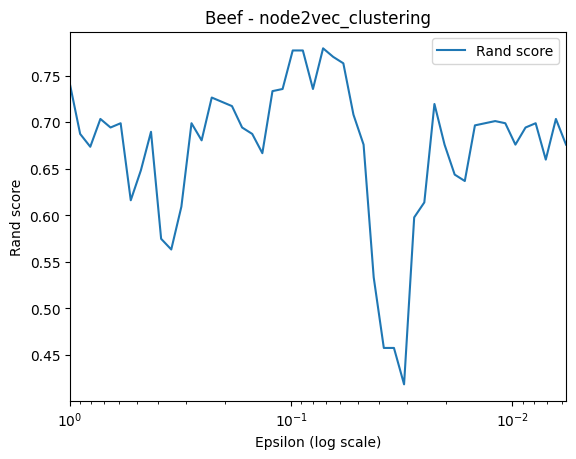

CinCECGTorso


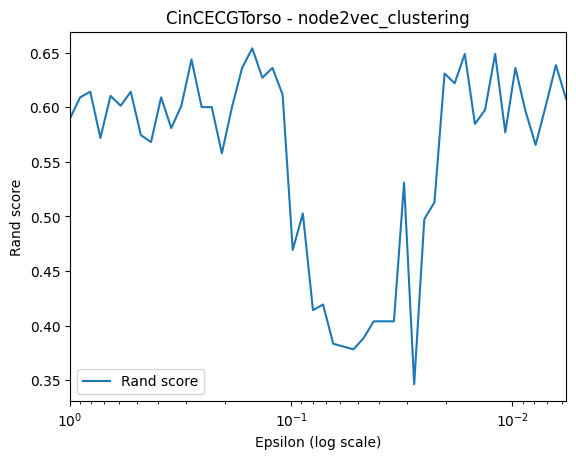

Coffee


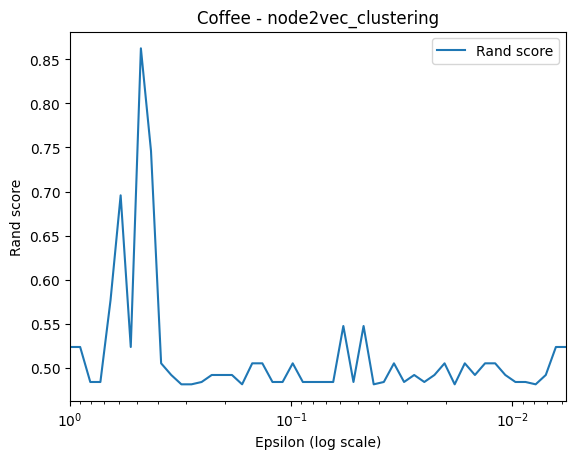

DiatomSizeReduction


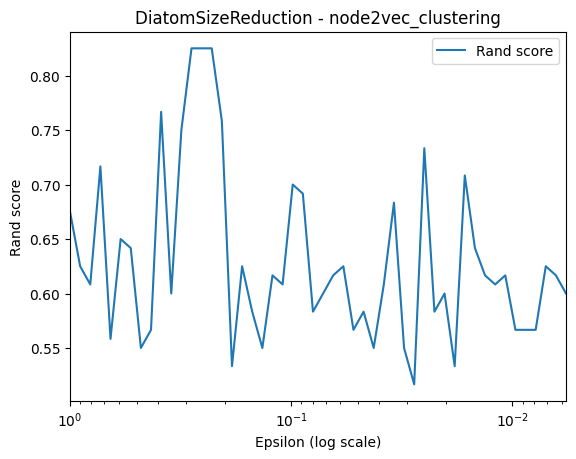

ECGFiveDays


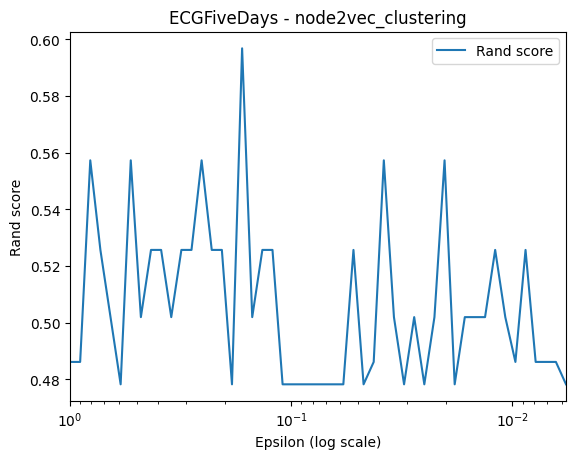

MoteStrain


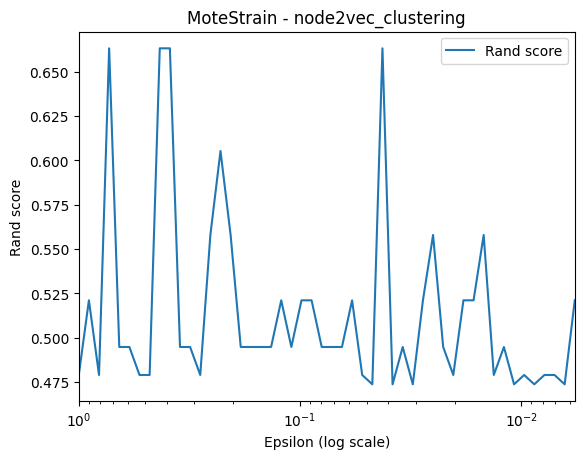

OliveOil


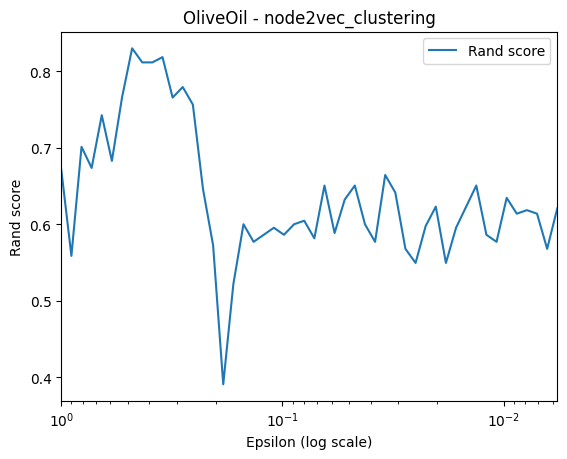

Symbols


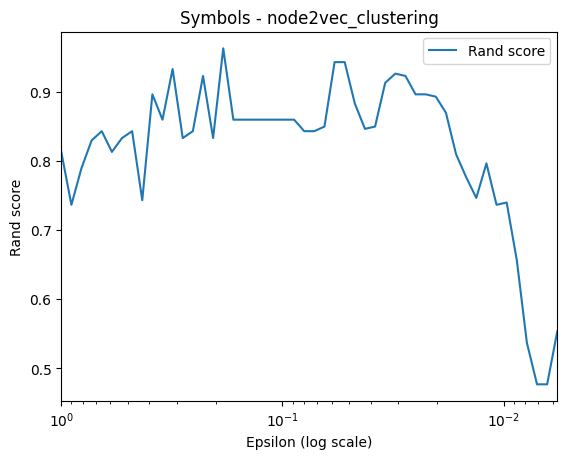

TwoLeadECG


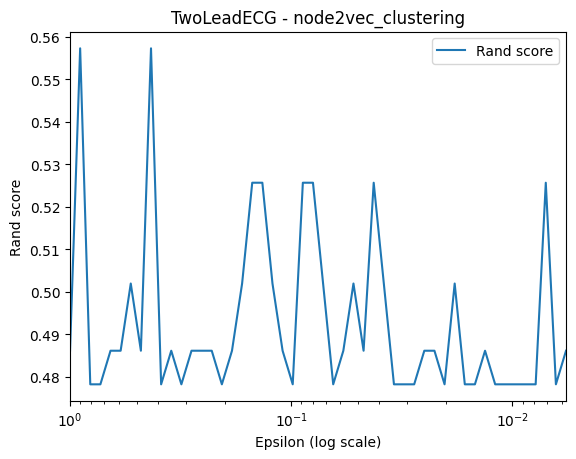

In [18]:
for dataset_name in output.keys():
    print(dataset_name)
    for method in output[dataset_name].keys():
        
        eps = output[dataset_name].get(method).get('eps')
        rands = output[dataset_name].get(method).get('rands')
        
        # Plotting in log scale
        plt.plot(eps, rands, label='Rand score')
        plt.xscale('log')  # Set x-axis to log scale
        plt.xlabel('Epsilon (log scale)')
        plt.ylabel('Rand score')
        plt.title(f'{dataset_name} - {method.__name__}')
        plt.xlim(eps[0], eps[-1])
        plt.legend()
        plt.show()
        break


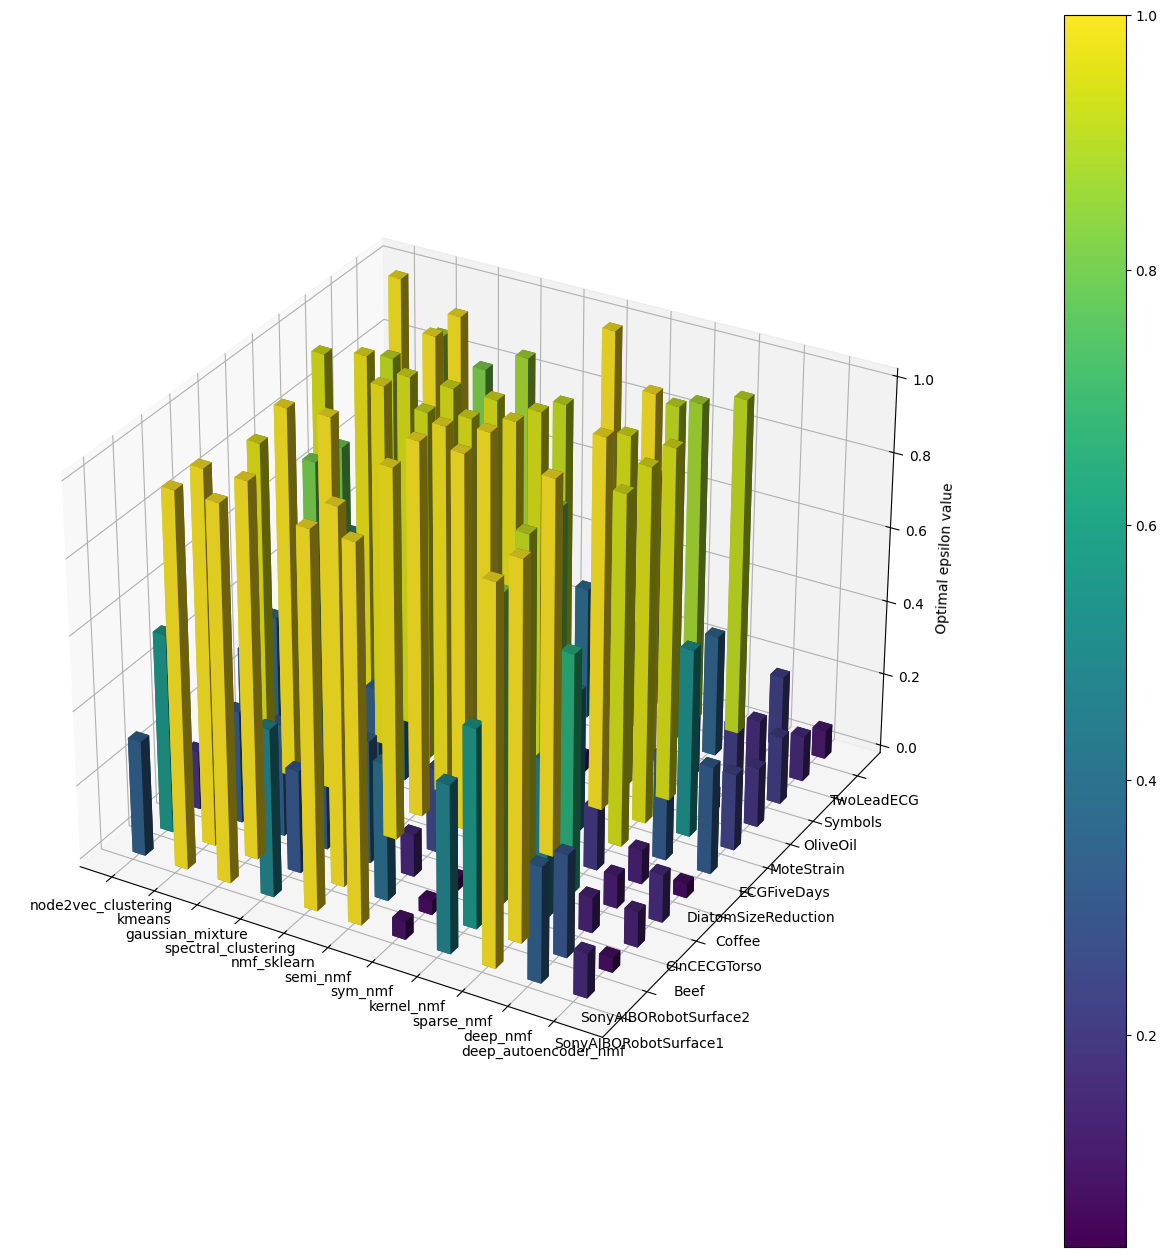

In [65]:
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

method_names = [method.__name__ for method in methods.keys()]
dataset_names = list(hyperparameters.keys())

data = np.array([[output[dataset_name][method]['epsilon_quantile'] for method in methods.keys()] for dataset_name in dataset_names])

# Create a meshgrid for x and y
x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))

# Flatten the arrays
x = x.flatten()
y = y.flatten()
z = np.zeros_like(x)

# Adjust the bar width and separation
bar_width = 0.3
bar_gap = 0.0

# Create a 3D plot
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D bars with color based on height
for xi, yi, zi, value in zip(x, y, z, data.flatten()):
    color = plt.cm.viridis(value / data.max())  # Use viridis colormap, adjust as needed
    ax.bar3d(xi, yi, zi, bar_width, bar_width, value, shade=True, color=color, zsort='max')

# Create a color scale along the z-axis
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(data.flatten())
cbar = plt.colorbar(mappable, ax=ax, pad=0.1)


# Customize x and y axis ticks and labels
ax.set_xticks(np.arange(len(method_names)))
ax.set_yticks(np.arange(len(dataset_names)))

ax.set_xticklabels(method_names)
ax.set_yticklabels(dataset_names)
# Set labels
#ax.set_xlabel('X-axis')
#ax.set_ylabel('Y-axis')
ax.set_zlabel('Optimal epsilon value')

plt.savefig(f'hist3D_best_rand.pdf')
# Show the plot
plt.show()


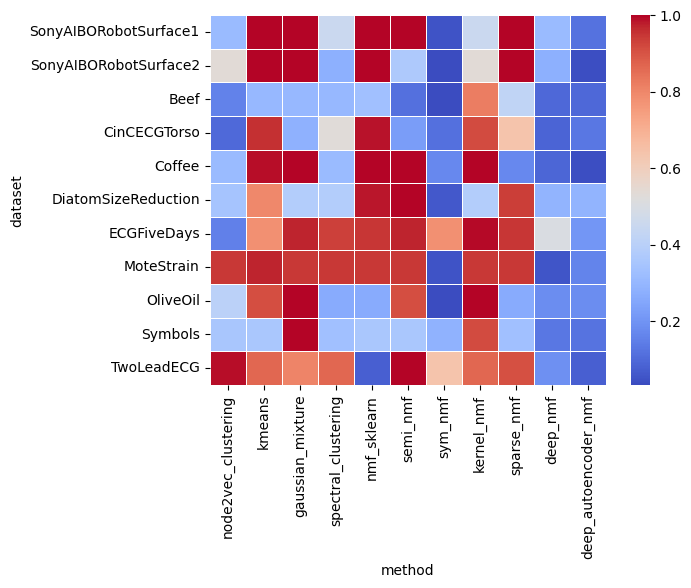

In [69]:
import seaborn as sns
ax = sns.heatmap(data, cmap='coolwarm', linewidth=0.5, xticklabels=method_names, yticklabels=dataset_names)
plt.ylabel('dataset')
plt.xlabel('method')
#plt.savefig(f'heatmap_eps_quantile.pdf')
plt.show()